In [3]:
import torch
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor as T, tensor as t

In [4]:
#Data of CO2 from AGC2019 and SIM_AGC2019 in 60 days
df_cli=pd.read_csv('data-nam.csv')
print (df_cli.head())

             timestamp  co2_Air  humidity_deficit  T_Grow_Pipe  T_Rail_Pipe   
0  2019-12-16 00:00:00    509.0               8.8      21.0000         49.9  \
1  2019-12-16 00:05:00    484.0               9.2      21.0333         48.5   
2  2019-12-16 00:10:00    475.0               9.1      21.0711         46.8   
3  2019-12-16 00:15:00    501.0               8.5      21.0864         45.2   
4  2019-12-16 00:20:00    487.0               8.5      21.1073         43.8   

   T_Air  sp_co2  sp_humidity_deficit  sp_Grow_Pipe_min  sp_heat  ...   
0   21.0   400.0                  4.3              10.0     21.0  ...  \
1   21.5   400.0                  4.3              10.0     21.0  ...   
2   21.6   400.0                  4.3              10.0     21.0  ...   
3   21.3   400.0                  4.3              10.0     21.0  ...   
4   21.4   400.0                  4.3              10.0     21.0  ...   

   T_Soil_Ext     vp_Out     vp_Air  co2_Out  u_Roof_Vent  plant_density   
0    7.559

In [5]:
df_cli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47809 entries, 0 to 47808
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            47809 non-null  object 
 1   co2_Air              47809 non-null  float64
 2   humidity_deficit     47809 non-null  float64
 3   T_Grow_Pipe          47809 non-null  float64
 4   T_Rail_Pipe          47809 non-null  float64
 5   T_Air                47809 non-null  float64
 6   sp_co2               47809 non-null  float64
 7   sp_humidity_deficit  47809 non-null  float64
 8   sp_Grow_Pipe_min     47809 non-null  float64
 9   sp_heat              47809 non-null  float64
 10  sp_Rail_Pipe_min     47809 non-null  float64
 11  sp_Roof_Vent         47809 non-null  float64
 12  rad_Out              47809 non-null  float64
 13  par_Out              47809 non-null  float64
 14  is_rain              47809 non-null  float64
 15  T_Out                47809 non-null 

In [6]:
N, d=df_cli.shape
data=np.array([df_cli['T_Air'],df_cli['T_Out'],df_cli['T_Rail_Pipe'],df_cli['T_Grow_Pipe'],
               df_cli['airflow_Out'],df_cli['vp_Air'] ,df_cli['vp_Out'],
               df_cli['sp_Roof_Vent'],df_cli['sp_humidity_deficit'],
               df_cli['sp_Rail_Pipe_min'], df_cli['sp_Grow_Pipe_min'],df_cli['sp_heat'],
               df_cli['vent_lee'],df_cli['vent_wind'],df_cli['u_Roof_Vent'],
               df_cli['u_Screen_1'],df_cli['u_Screen_2'],
               df_cli['u_TopLight'],df_cli['u_Interlight'],
               ]).T
print(data.shape)

(47809, 19)


In [7]:
xaxis=np.zeros((N,1))
for i in range (0,N-1):
    xaxis[i,0]=i+1

In [8]:
timestamp=300 #s
air_height=4.5  # [m]
vent_height=0.7783 # [m]
discharge_coef=0.3
normalized_area=0.175 # [m2{roof_vent}/m2{gh}]
GRAVITY=9.81 # [m/s^2]
wind_pressure_coef=0.01725
K0=273.15  # absolute temperature at 0C
VP_SAT_PRE_EXP = 610.78
VP_SAT_EXP_COEF = 17.27
VP_SAT_TEMP_COEF = 237.3
# Molar mass of water.
# Unit: kg kmol^-1
M_WATER = 18.01528
KILO = 1.0E3
GAS_R = 8.314462E3  # Molar gas constant R in ideal gas law: PV=nRT [J/kmol/K]
GAS_R_MOL = GAS_R / KILO  # [J/mol/K]
# Reference temperature for calculating air density
# default = 25 [Celsius]
AIR_DENSITY_TEMP = 25.0
K0 = 273.15  # absolute temperature at 0C
APPROX_TEMPERATURE_KELVIN = K0 + AIR_DENSITY_TEMP  # default temperature used in linear approximations
# conversion factor from pascal to g/m3
PASCAL_TO_GM3 = M_WATER / (GAS_R_MOL * APPROX_TEMPERATURE_KELVIN)
# Density of steel.
# Unit: kg m^-3
STEEL_DENSITY = 7850
# Density of water.
# Unit: kg m^-3
WATER_DENSITY = 1E3
# Density of the air at sea level.
# Unit: kg m^-3
DENSITY_AIR0 = 1.20
# Specific heat capacities of materials: https://en.wikipedia.org/wiki/Table_of_specific_heat_capacities
# Unit: J/K/kg
HEAT_CAPACITY_AIR = 1E3
HEAT_CAPACITY_WATER = 4.18E3
HEAT_CAPACITY_STEEL = 0.64E3

diameter_external_rail= 0.089  # [m] HEC_pipe_air = 11.3 * 3.14 * 0.089 / 1.5 = 2.1 W/m2{gh}/K
diameter_internal_rail= 0.084  # [m]
diameter_external_grow= 0.026  # [m] HEC_pipe_air = 11.3 * 3.14 * 0.089 / 1.5 = 2.1 W/m2{gh}/K
diameter_internal_grow= 0.0235  # [m]
distance_between_pipes= 1.5 # [m]
boiler_capacity_rail=180 #W/m^2
boiler_capacity_grow=30 #W/m^2

humidity_deficit_threshold=4.9 # [g/m3]
humidity_deficit_upper_bound=5.2 # g/m3

In [9]:
# Tool to calculate u_value
def vp_saturation(t: np, _VP_SAT_PRE_EXP=np.array(VP_SAT_PRE_EXP), _VP_SAT_EXP_COEF=np.array(VP_SAT_EXP_COEF),
                  _VP_SAT_TEMP_COEF=np.array(VP_SAT_TEMP_COEF)) -> np:  # Pascal
    # ref: https://en.wikipedia.org/wiki/Tetens_equation
    return _VP_SAT_PRE_EXP * np.exp(_VP_SAT_EXP_COEF * t / (t + _VP_SAT_TEMP_COEF))
def vp_saturation_inverse (
    vp_sat: np, _VP_SAT_PRE_EXP=np.array(VP_SAT_PRE_EXP), _VP_SAT_EXP_COEF=np.array(VP_SAT_EXP_COEF),
    _VP_SAT_TEMP_COEF=np.array(VP_SAT_TEMP_COEF) ) -> np:  # Celsius
#   ref: https://en.wikipedia.org/wiki/Tetens_equation
    c = np.log(vp_sat / _VP_SAT_PRE_EXP)
    return c * _VP_SAT_TEMP_COEF / (_VP_SAT_EXP_COEF - c)
def proportional_control (
#   sp: T, cur: T, band: T, direction: T = t(1) ) -> T:
    sp: T, cur: T, band: T, direction: T = torch.tensor(1.) ) -> T:
# direction is positive if we need to increase cur to sp (e.g. heating) and negative otherwise (ventilation)
    diff = torch.tensor(sp - cur) * direction
# return torch.clip(diff / band, 0, 1)  # we assume the output of proportional control is always between 0 and 1
    return soft_zero_one_clip(diff / band, temperature=t(7.))
# smooth control function
def soft_zero_one_clip ( x, temperature=torch.tensor(4.0) ):
    return torch.sigmoid((x - 0.5) * temperature)
def heat_capacity (diameter_external,diameter_internal):
#   Equation 8.22:
    thickness = (diameter_external - diameter_internal) / 2
    steel_heat_cap = thickness * surface_area(diameter_external) * STEEL_DENSITY * HEAT_CAPACITY_STEEL
    water_volume = math.pi * (diameter_internal / 2) ** 2 / distance_between_pipes
    water_heat_cap = water_volume * WATER_DENSITY * HEAT_CAPACITY_WATER
    return steel_heat_cap + water_heat_cap
def surface_area(diameter_external):
#   returns both the surface area and the view area
    surface_area = math.pi * diameter_external  # per 1m length
    surface_area_normalized = surface_area / distance_between_pipes  # normalize per 1m2 of floor
    return surface_area_normalized

In [10]:
def _u_roof_vent( T_Air, T_Out, airflow_Out,vp_Air,vp_Out, sp_Roof_Vent, sp_humidity_deficit ) -> np:
    sp, sp_hum_def = sp_Roof_Vent, sp_humidity_deficit
    temp_diff = T_Air - T_Out
    temp_mean = (T_Air + T_Out) / 2 + K0
     # air flow when vent is 100 percent open [m3/m2/s]
    f = discharge_coef * normalized_area / 2 \
        * np.sqrt(GRAVITY * vent_height / 2 * np.absolute(temp_diff) / temp_mean + wind_pressure_coef * airflow_Out ** 2)
    power = f * temp_diff
    band = np.maximum(power * timestamp / air_height, 10 * np.ones_like(power))
    mask = temp_diff > 0.5
    u = np.zeros_like(T_Air)
    u[mask] = proportional_control(sp, T_Air, band, direction=t(-1))[mask]
    # this is for dehumidification by vent
    u_vp = np.zeros_like(u)
    sp_vp = vp_saturation(T_Air) - sp_hum_def / PASCAL_TO_GM3
    vp_diff = sp_vp - vp_Out
    band_vp = np.maximum(f * timestamp * vp_diff / air_height, 500 * np.ones_like(sp_vp))
    mask_vp = vp_diff > 50.0
    u_vp[mask_vp] = proportional_control(sp_vp, vp_Air, band_vp, direction=t(-1))[mask_vp]
    u_vent=np.maximum(u, u_vp)
    return u_vent

In [11]:
    def _u_top_light():
        if check_value_exist(u_TopLight):
            return u_TopLight
        else:
            return sp_TopLight

    def _u_inter_light():
        if check_value_exist(u_Interlight):
            return u_Interlight
        else:
            return sp_Interlight

In [12]:
def _u_rail_pipe( sp_Rail_Pipe_min, sp_heat, sp_humidity_deficit, vp_Air, T_Air, T_Rail_Pipe ) -> np:
    cap_air = air_height * HEAT_CAPACITY_AIR * DENSITY_AIR0
    power = boiler_capacity_rail
    band_air = power * timestamp / cap_air
    band_pipe = power * timestamp / heat_capacity(diameter_external_rail,diameter_internal_rail)
    sp_pipe, sp_heat, sp_hum_def = sp_Rail_Pipe_min, sp_heat, sp_humidity_deficit
# take into account heat loss due to ventilating dehumidification
    sp_vp = vp_Air + sp_hum_def / PASCAL_TO_GM3
    sp_heat = np.maximum( sp_heat, vp_saturation_inverse(sp_vp) )
    u_air  = proportional_control ( sp_heat, T_Air,       band_air )
    u_pipe = proportional_control ( sp_pipe, T_Rail_Pipe, band_pipe )
    u = np.maximum( np.array(u_air), np.array(u_pipe) )    
    return u
def _u_grow_pipe(sp_Grow_Pipe_min, sp_heat, sp_humidity_deficit, vp_Air, T_Air, T_Grow_Pipe ) -> np:
    cap_air = air_height * HEAT_CAPACITY_AIR * DENSITY_AIR0
    power = boiler_capacity_grow
    band_air = power * timestamp / cap_air
    band_pipe = power * timestamp / heat_capacity(diameter_external_grow,diameter_internal_grow)
    sp_pipe, sp_heat, sp_hum_def = sp_Grow_Pipe_min, sp_heat, sp_humidity_deficit
    # take into account heat loss due to ventilating dehumidification
    sp_vp = vp_Air + sp_hum_def / PASCAL_TO_GM3
    sp_heat = np.maximum(sp_heat, vp_saturation_inverse(sp_vp))
    u_air = proportional_control(sp_heat, T_Air, band_air)
    u_pipe = proportional_control(sp_pipe, T_Grow_Pipe, band_pipe)
    u = np.maximum( np.array(u_air), np.array(u_pipe) ) 
    return u

In [13]:
def _u_co2():
    if check_value_exist(u_co2):
        return u_co2
    else:
    # co2 is reported in ppm
        return (co2_Air < sp_co2).float()

def _u_fog_func(T_Air,vp_Air,sp_humidity_deficit):
    u = np.zeros_like(T_Air)
    # https://www2.gov.bc.ca/assets/gov/farming-natural-resources-and-industry/agriculture[…]-and-crops/crop-production/understanding_humidity_control.pdf
    humidity_deficit = (vp_saturation(T_Air) - vp_Air) * PASCAL_TO_GM3
    mask = humidity_deficit > humidity_deficit_threshold
    u[mask] = proportional_control(sp_humidity_deficit, humidity_deficit, humidity_deficit_upper_bound, direction=t(-1))[mask]  # assuming spraying for 1 min
    return u

In [14]:
u_rail_pipe=np.array([_u_rail_pipe(
    sp_Rail_Pipe_min=data[:,9], 
    sp_heat=data[:,11], 
    sp_humidity_deficit=data[:,8],
    vp_Air=data[:,5], 
    T_Air=data[:,0], 
    T_Rail_Pipe=data[:N,5] )]).T
u_grow_pipe=np.array([_u_grow_pipe(
    sp_Grow_Pipe_min=data[:,10], 
    sp_heat=data[:,11], 
    sp_humidity_deficit=data[:,8],
    vp_Air=data[:,5], 
    T_Air=data[:,0], 
    T_Grow_Pipe=data[:N,5] )]).T
#u_co2=np.array([_u_co2()]).T
#u_fog=np.array([_u_fog_func()]).T
u_roof_vent=np.array([_u_roof_vent(
    T_Air=data[:,0],
    T_Out=data[:,1],
    airflow_Out=data[:,4],
    vp_Air=data[:,5],
    vp_Out=data[:,6],
    sp_Roof_Vent=data[:,7],
    sp_humidity_deficit=data[:,8] )]).T
#u-top_light=np.array([_u_top_light()]).T
#u_inter_light=np.array([_u_inter_light()]).T

In [15]:
#np.savetxt('u_roof_vent.txt',np.column_stack((xaxis,u_roof_vent,data[:,14],u_grow_pipe,u_rail_pipe)))

In [43]:
diff=u_roof_vent-np.array([data[:,14]]).T
print(diff.shape)

(47809, 1)


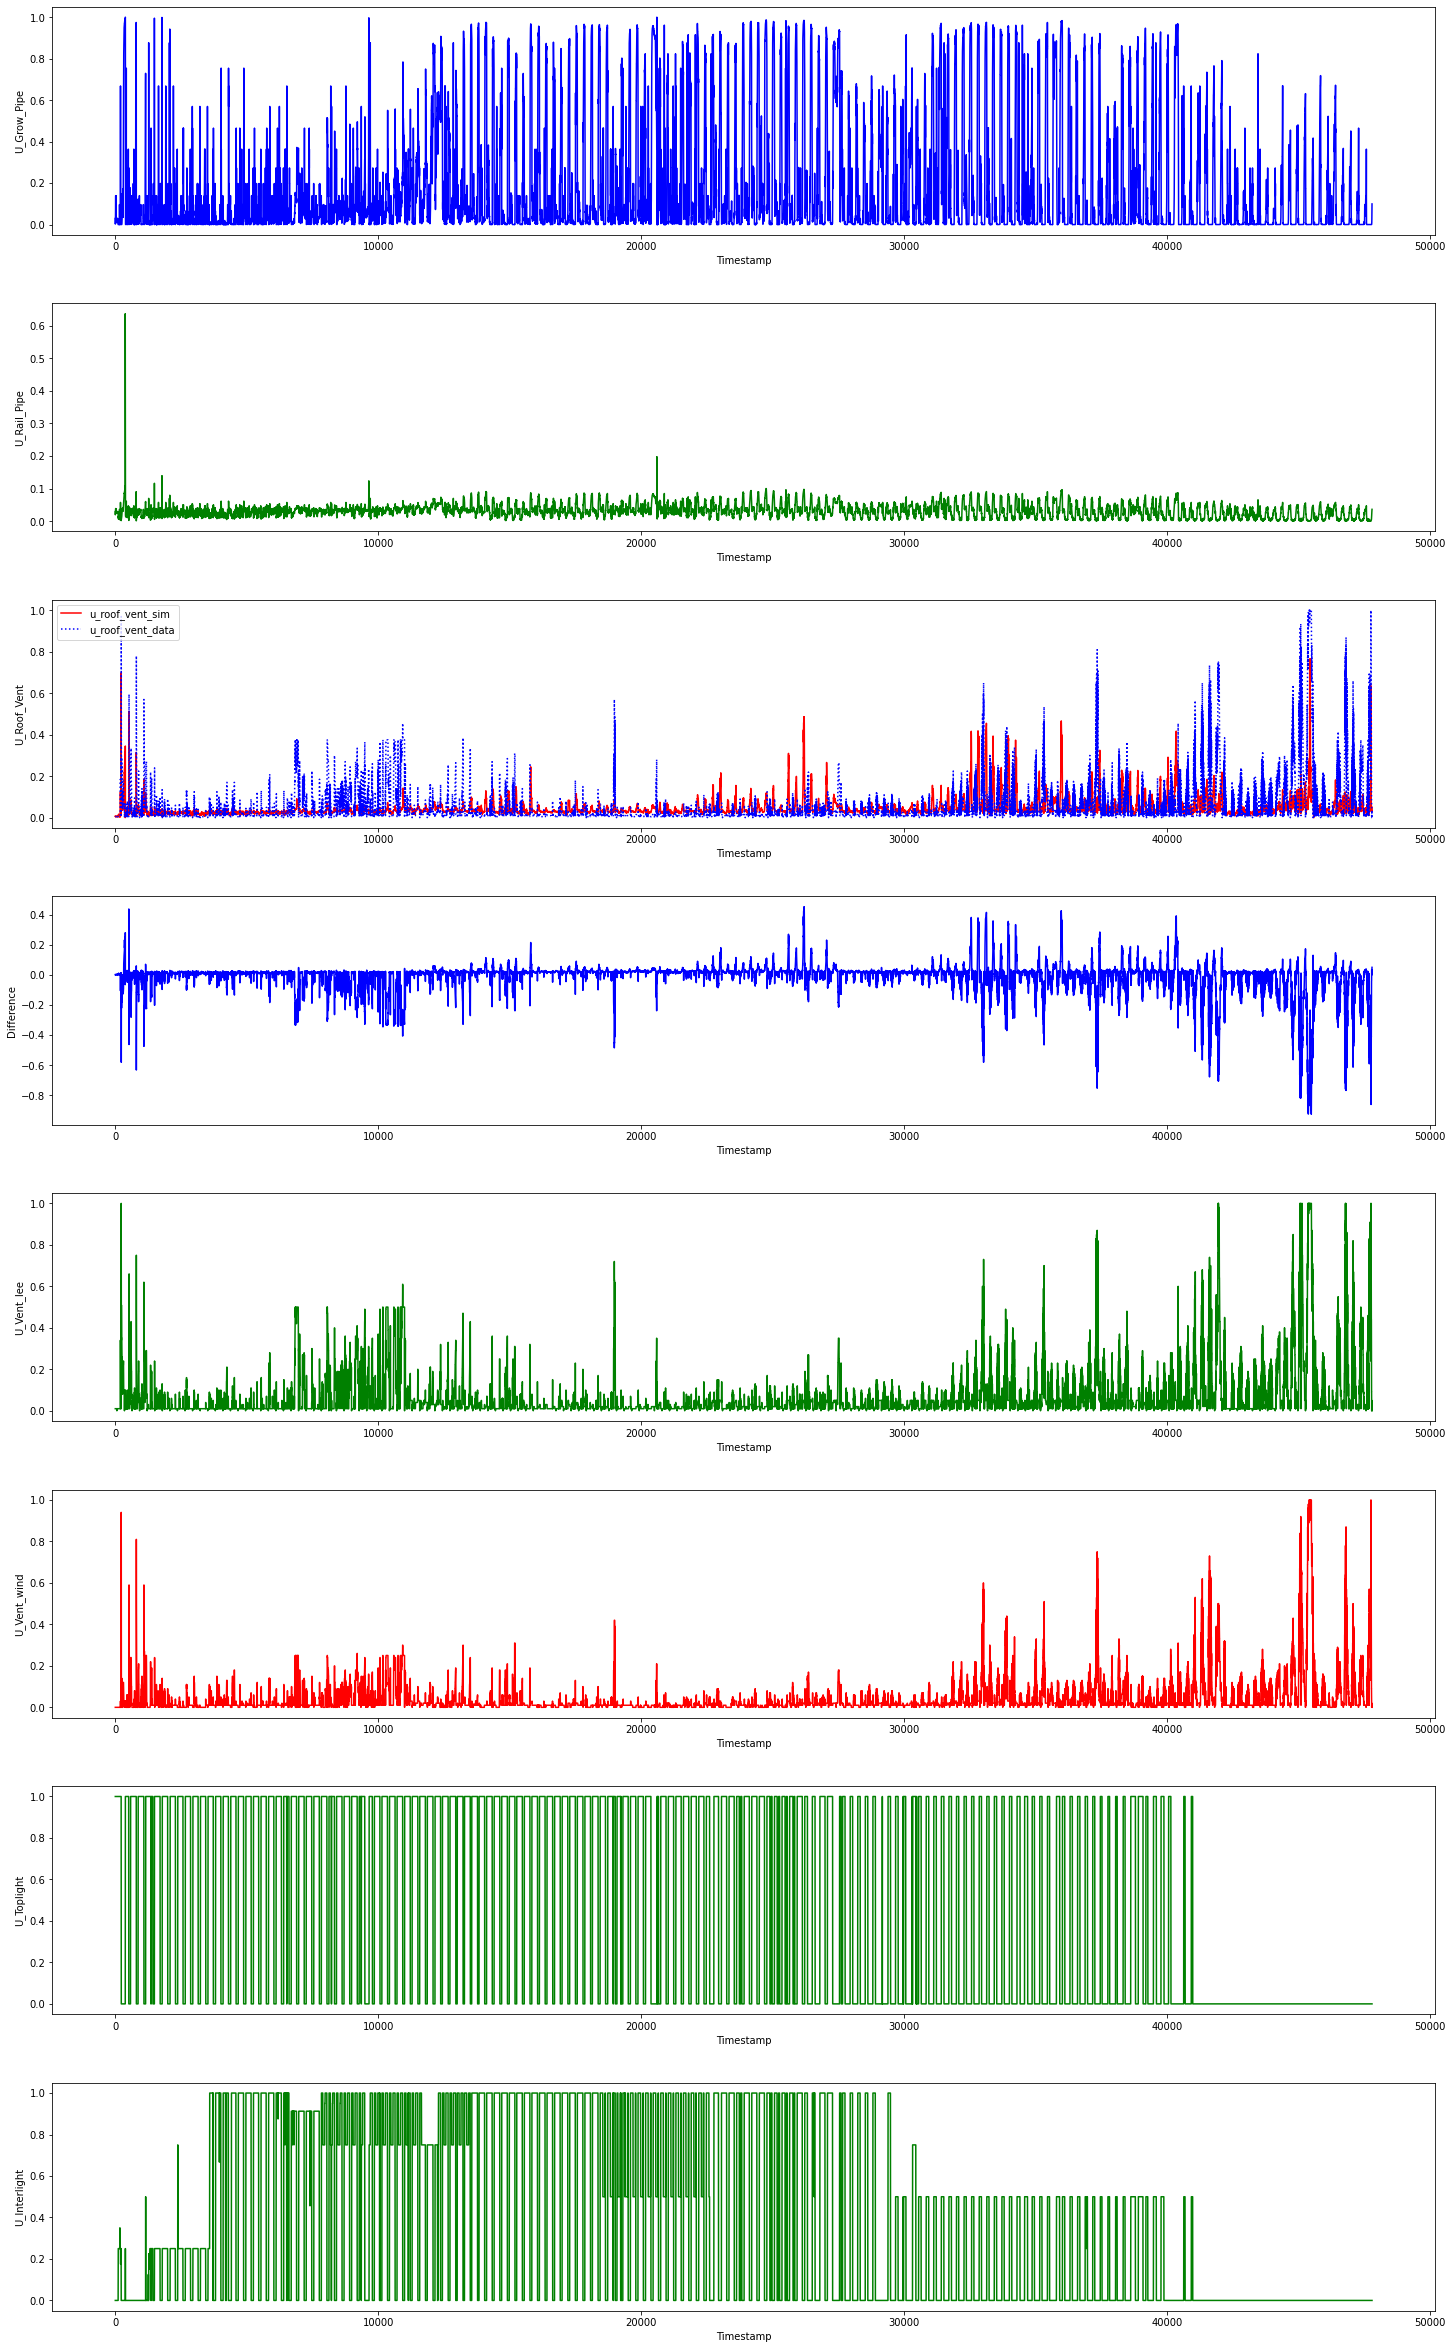

In [46]:
fig, axs=plt.subplots(nrows=8, figsize=(24,40))

axs[0].plot(u_grow_pipe, linestyle='-', color='b', label='u_grow_pipe')
axs[1].plot(u_rail_pipe, linestyle='-', color='g', label='u_rail_pipe')
axs[2].plot(u_roof_vent, linestyle='-', color='r', label='u_roof_vent_sim')
axs[2].plot(data[:,14], linestyle='dotted', color='b', label='u_roof_vent_data')
axs[3].plot(diff, linestyle='-', color='b')
axs[4].plot(data[:,12], linestyle='-', color='g', label='u_vent_lee')
axs[5].plot(data[:,13], linestyle='-', color='r', label='u_vent_wind')
axs[6].plot(data[:,17], linestyle='-', color='g', label='u_Toplight')
axs[7].plot(data[:,18], linestyle='-', color='g', label='u_Interlight')
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.3)
axs[0].set_xlabel('Timestamp')
axs[1].set_xlabel('Timestamp')
axs[2].set_xlabel('Timestamp')
axs[3].set_xlabel('Timestamp')
axs[4].set_xlabel('Timestamp')
axs[5].set_xlabel('Timestamp')
axs[6].set_xlabel('Timestamp')
axs[7].set_xlabel('Timestamp')
axs[0].set_ylabel('U_Grow_Pipe')
axs[1].set_ylabel('U_Rail_Pipe')
axs[2].set_ylabel('U_Roof_Vent')
axs[3].set_ylabel('Difference')
axs[4].set_ylabel('U_Vent_lee')
axs[5].set_ylabel('U_Vent_wind')
axs[6].set_ylabel('U_Toplight')
axs[7].set_ylabel('U_Interlight')
axs[2].legend(loc='upper left')
plt.show()